In [34]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ["LANGCHAIN_API_KEY"] = os.getenv('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = os.getenv('LANGCHAIN_TRACING_V2')
os.environ["LANGCHAIN_ENDPOINT"] = os.getenv('LANGCHAIN_ENDPOINT')
os.environ["TAVILY_API_KEY"] = os.getenv('TAVILY_API_KEY')
os.environ["HF_HOME"] = os.getenv("HF_HOME")

MODEL_NAME = "llama-3.1-8b-instant"

In [35]:
from langchain_community.document_loaders import WebBaseLoader 
from langchain_community.vectorstores import FAISS 
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
doc_list = [doc for sublist in docs for doc in sublist]
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
doc_splits = text_splitter.split_documents(doc_list)

In [36]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(documents=doc_splits, embedding=embeddings)

retriever = vectorstore.as_retriever()

In [38]:
# Retriever Grader 

from langchain_core.prompts import ChatPromptTemplate 
from pydantic import BaseModel, Field 

class GradeDocument(BaseModel):
    """Binary score for relevance check of retrieved documents"""

    binary_score: str = Field(descrition="Documents are relevant to the question 'yes' or 'no'")

C:\Users\indra\AppData\Local\Temp\ipykernel_26212\2939042521.py:9: PydanticDeprecatedSince20: Using extra keyword arguments on `Field` is deprecated and will be removed. Use `json_schema_extra` instead. (Extra keys: 'descrition'). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  binary_score: str = Field(descrition="Documents are relevant to the question 'yes' or 'no'")


In [39]:
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

llm = ChatGroq(model=MODEL_NAME)
structured_llm_grader = llm.with_structured_output(GradeDocument)

In [ ]:
# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        "system", system,
        "human", "Retrieved document:\n{document}\n\n User question: {question}"
    ]
)
retrieval_grader = grade_prompt | structured_llm_grader

question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content 

print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [41]:
### Question Re-writer
llm = ChatGroq(model=MODEL_NAME)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'Based on the initial question, I would formulate an improved question as:\n\n"What is agent memory and how does it work in [specific context or application]?"\n\nThis improved question aims to:\n\n1. Add specificity to the search query by including the context or application of agent memory.\n2. Clarify the intent behind the question, which is to understand the concept and functionality of agent memory.\n3. Increase the chances of finding relevant and accurate information through search engines.\n\nAlternatively, I could also rephrase the question to:\n\n"What are the characteristics and benefits of agent memory in artificial intelligence?"\nor\n"How does agent memory contribute to the decision-making process in autonomous systems?"\n\nThese variations aim to capture the underlying intent of the initial question while providing more specific and focused search queries.'

In [ ]:
# Generate 

from langchain import hub 
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

# Input vars - context, question
prompt = hub.pull("rlm/rag-prompt")

llm = ChatGroq(model=MODEL_NAME)

rag_chain = prompt | llm | StrOutputParser()

generation = rag_chain.invoke({"context": docs, "question": question})


In [54]:
from typing import List 
from typing_extensions import TypedDict 

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    question: str 
    generation: str 
    web_search: str 
    documents: List[str]

In [55]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """ 
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG Generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {
        "documents": documents, "question": question, "generation": generation
    }

def grade_document(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each document 
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke({
          "question": question, "document": d.page_content   
        })
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    
    return {
        "documents": filtered_docs,
        "question": question,
        "web_search": web_search
    }

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    print("existing docs", documents)
    print("web results", web_results)

    documents.append(web_results)

    return {"documents": documents, "question": question}

# Edges 
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---", state["question"], state["web_search"])
    web_search = state["web_search"]

    if web_search == "Yes":
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else: 
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


In [56]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_document)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

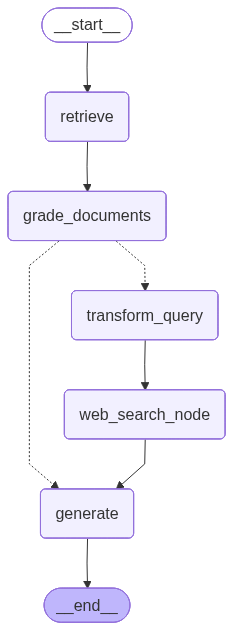

In [57]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [58]:
app.invoke({"question":"What are the types of agent memory?"})

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS--- What are the types of agent memory? No
---DECISION: GENERATE---
---GENERATE---


{'question': 'What are the types of agent memory?',
 'generation': 'The types of agent memory are short-term memory and long-term memory. Short-term memory is used for in-context learning and is short and finite. Long-term memory is an external vector store that allows the agent to retain and recall information over extended periods.',
 'web_search': 'No',
 'documents': [Document(id='7ad02ccd-1e8b-44d0-aea7-9484f06fb6c2', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions